In [1]:
import numpy as np
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
)
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold, train_test_split

import catboost as cb


import util

In [2]:
RANDOM_SEED = 42

In [3]:
ORIGINS_PATH = "/storage2/tbrekalo/HG002-simulated/chr19-read-origins.csv"
df_origins = util.load_origins_df(ORIGINS_PATH)

In [4]:
MINIMAP2_OVLPS = "/storage2/tbrekalo/HG002-simulated/chr19-sample-minimap2-ovlps.paf"
RAM_OVLPS_AI = "/storage2/tbrekalo/HG002-simulated/chr19-sample-ram-ovlps-ai.tsv"
RAM_OVLPS = "/storage2/tbrekalo/HG002-simulated/chr19-sample-ram-ovlps.paf"

In [5]:
df_ovlps_minimap2 = util.create_annotated_overlaps_from_ava(
    util.load_paf_df(MINIMAP2_OVLPS),
    df_origins,
)

In [6]:
df_ovlps_ai_ram = (
    util.calc_ava_origin_overlap(
        util.expand_ava_with_origin_info(
            df_ava=pl.read_csv(
                RAM_OVLPS_AI,
                has_header=False,
                new_columns=util.RAM_OVERLAP_AI_COLUMNS,
                separator="\t",
            ),
            df_origins=df_origins,
        )
    )
    .select(
        *util.RAM_OVERLAP_AI_COLUMNS,
        ((pl.col("ratio") > 0.825) & pl.col("matching-strands"))
        .cast(pl.Int64)
        .alias("label"),
    )
    .with_columns(
        pl.when(pl.col("strand") == "+")
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .alias("strand"),
        pl.min_horizontal(
            pl.col("query-matches"),
            pl.col("target-matches"),
        ).alias("n-residue-matches"),
    )
)

In [172]:
df_ovlps_ram = util.create_annotated_overlaps_from_ava(
    util.load_paf_df(RAM_OVLPS),
    df_origins,
)

In [173]:
print(df_ovlps_minimap2.select(pl.col("label").value_counts()))
print(df_ovlps_ai_ram.select(pl.col("label").value_counts()))
print(df_ovlps_ram.select(pl.col("label").value_counts()))

shape: (2, 1)
┌────────────┐
│ label      │
│ ---        │
│ struct[2]  │
╞════════════╡
│ {1,11923}  │
│ {0,296419} │
└────────────┘
shape: (2, 1)
┌───────────┐
│ label     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {1,2183}  │
│ {0,84169} │
└───────────┘
shape: (2, 1)
┌───────────┐
│ label     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {1,1224}  │
│ {0,50866} │
└───────────┘


In [9]:
OFFESET = 0
ANGLE = 0 * np.pi

In [10]:
df_experiment = (
    df_ovlps_ai_ram.with_columns(
        (pl.col("query-end") - pl.col("query-start")).alias("query-overlap-length"),
        (pl.col("target-end") - pl.col("target-start")).alias("target-overlap-length"),
    )
    .with_columns(
        pl.max_horizontal(
            pl.col("query-overlap-length"),
            pl.col("target-overlap-length"),
        ).alias("overlap-length"),
        (pl.col("query-overlap-length") - pl.col("target-overlap-length"))
        .abs()
        .alias("overlap-length-diff"),
    )
    .with_columns(
        (pl.col("score") / pl.col("overlap-length")).alias("score-normed"),
        (pl.col("query-matches") / pl.col("query-overlap-length")).alias(
            "query-matches-normed"
        ),
        (pl.col("target-matches") / pl.col("target-overlap-length")).alias(
            "target-matches-normed"
        ),
        (pl.col("n-residue-matches") / pl.col("overlap-length")).alias(
            "matches-normed"
        ),
    )
    .with_columns(
        (pl.col("query-matches-normed") - pl.col("target-matches-normed"))
        .abs()
        .alias("matches-normed-diff")
    )
    .with_columns(
        (
            (pl.col("matches-normed-diff") + OFFESET) * np.cos(ANGLE)
            + (pl.col("matches-normed-diff") + OFFESET).pow(2) * np.sin(ANGLE)
        ).alias("matches-normed-diff-rot")
    )
    .with_columns(
        (
            (pl.col("matches-normed-diff") + OFFESET) * np.sin(ANGLE)
            - (pl.col("matches-normed-diff") + OFFESET).pow(2) * np.cos(ANGLE)
        ).alias("matches-normed-diff-y-rot")
    )
)

In [119]:
df_experiment_lhs = df_experiment.filter(pl.col("matches-normed-diff") < 0.05)
df_experiment_rhs = df_experiment.filter(pl.col("matches-normed-diff") >= 0.05)

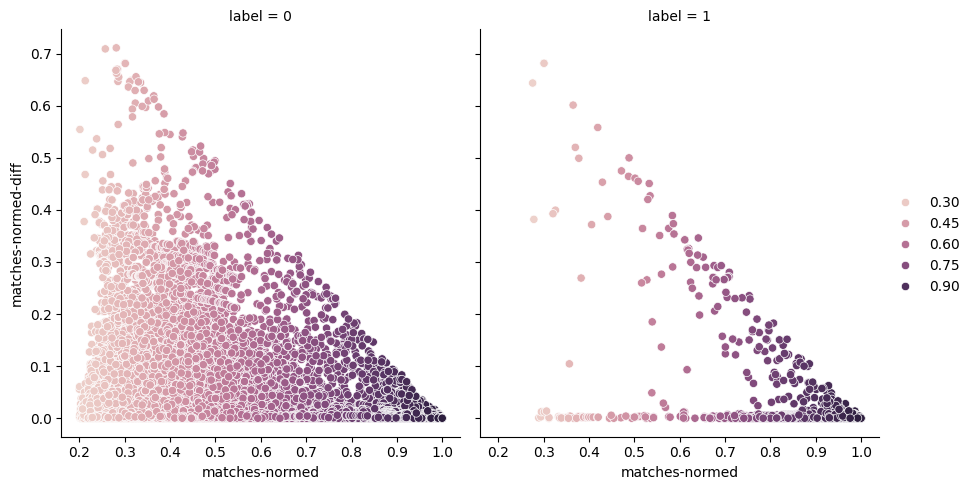

In [120]:
g = sns.FacetGrid(
    df_experiment,
    col="label",
)
g.fig.set_size_inches(9, 5)
g.map_dataframe(
    sns.scatterplot,
    x="matches-normed",
    y="matches-normed-diff",
    hue="matches-normed",
)
g.add_legend()

In [154]:
df_features = df_experiment.select(
    pl.col("score-normed"),
    pl.col("matches-normed"),
    pl.col("matches-normed-diff"),
    pl.col("label"),
)

df_features_lhs = df_features.filter(pl.col("matches-normed-diff") < 0.1)
df_features_rhs= df_features.filter(pl.col("matches-normed-diff") >= 0.1)

In [155]:
X_lhs = df_features_lhs.drop("label").to_pandas()
y_lhs = df_features_lhs["label"].to_pandas()

X_rhs = df_features_rhs.drop("label").to_pandas()
y_rhs = df_features_rhs["label"].to_pandas()

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [156]:
model_ridge_lhs = RidgeClassifier(
    class_weight="balanced",
    random_state=RANDOM_SEED,
)

model_ridge_rhs = RidgeClassifier(
    class_weight="balanced",
    random_state=RANDOM_SEED,
)

In [157]:
X_lhs_train, X_lhs_test, y_lhs_train, y_lhs_test = train_test_split(
    X_lhs, y_lhs, train_size=0.7, random_state=RANDOM_SEED)

X_rhs_train, X_rhs_test, y_rhs_train, y_rhs_test = train_test_split(
    X_rhs, y_rhs, train_size=0.7, random_state=RANDOM_SEED)

model_ridge_lhs.fit(X_lhs_train, y_lhs_train)
model_ridge_rhs.fit(X_rhs_train, y_rhs_train)

RidgeClassifier(class_weight='balanced', random_state=42)

In [158]:
y_lhs_pred_ridge = model_ridge_lhs.predict(X_lhs_test)
y_rhs_pred_ridge = model_ridge_rhs.predict(X_rhs_test)

In [159]:
print("lhs:")
print(classification_report(y_lhs_test, y_lhs_pred_ridge))
print("rhs:")
print(classification_report(y_rhs_test, y_rhs_pred_ridge))

lhs:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81     24028
           1       0.07      0.90      0.13       649

    accuracy                           0.69     24677
   macro avg       0.53      0.79      0.47     24677
weighted avg       0.97      0.69      0.79     24677

rhs:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1190
           1       0.17      0.95      0.28        40

    accuracy                           0.84      1230
   macro avg       0.58      0.90      0.60      1230
weighted avg       0.97      0.84      0.89      1230



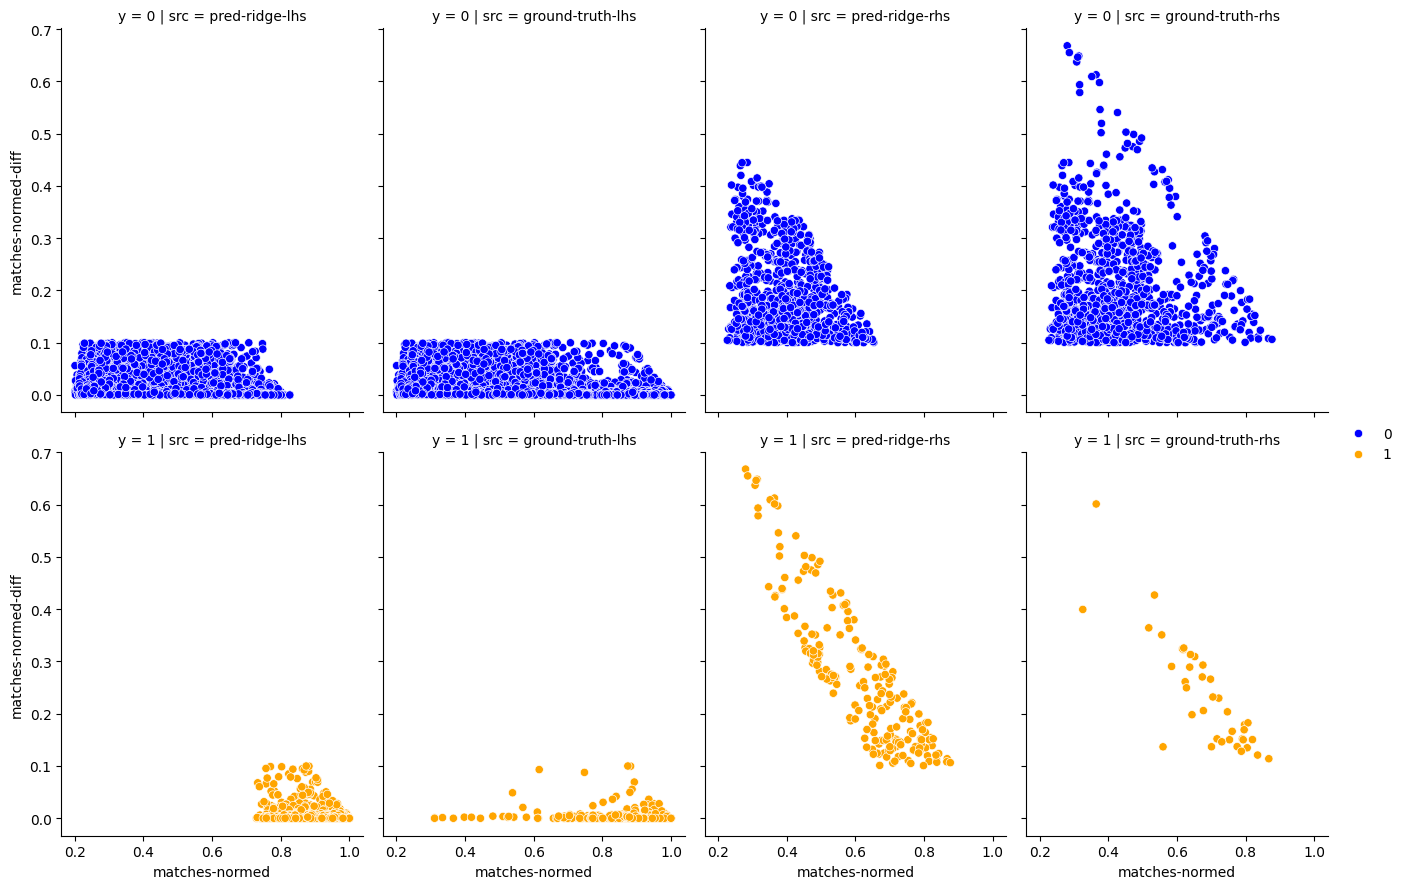

In [160]:
df_result = pd.concat(
    [
        X_lhs_test.assign(y=y_lhs_pred_ridge, src="pred-ridge-lhs"),
        X_lhs_test.assign(y=y_lhs_test, src="ground-truth-lhs"),
        X_rhs_test.assign(y=y_rhs_pred_ridge, src="pred-ridge-rhs"),
        X_rhs_test.assign(y=y_rhs_test, src="ground-truth-rhs"),
    ],
)
g = sns.FacetGrid(df_result, col="src", row="y")
g.fig.set_size_inches(13.5, 9)
g.map_dataframe(
    sns.scatterplot,
    x="matches-normed",
    y="matches-normed-diff",
    hue="y",
    palette={
        0: 'blue',
        1: 'orange',
    },
)
g.add_legend()

In [161]:
print(list(zip(model_ridge_lhs.feature_names_in_, *model_ridge_lhs.coef_)))
print(model_ridge_lhs.intercept_)

[('score-normed', -3.7106235417527986), ('matches-normed', 5.468803244688338), ('matches-normed-diff', 0.1347422495493317)]
[-2.38084641]


In [162]:
print(list(zip(model_ridge_rhs.feature_names_in_, *model_ridge_rhs.coef_)))
print(model_ridge_rhs.intercept_)

[('score-normed', -0.7543529858381203), ('matches-normed', 4.60687664446948), ('matches-normed-diff', 3.8180060955855275)]
[-3.15016052]
